---

# Generate datasets

In [4]:
# import libraries we need
%pylab inline
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
tfd = tfp.distributions

import sys
sys.path.append('./../py_programs/')
from Simulator import *
from keract import get_activations


Populating the interactive namespace from numpy and matplotlib


### Generate data files with two fixed mixed sources,  **saved in `Old_data`**

<Figure size 432x288 with 0 Axes>

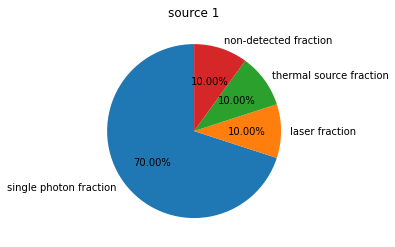

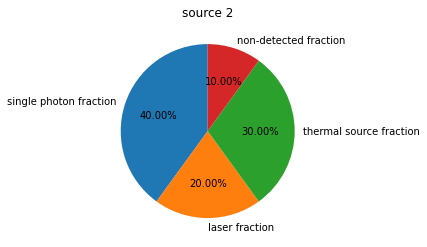

In [6]:
# create two mixed sources and corresponding two distributions
s1 = simulator(Nbins=200, Ndet=1e6, nset=100, sps=0.7, laser=0.1, ther=0.1, non=0.1)
s2 = simulator(Nbins=200, Ndet=1e6, nset=100, sps=0.4, laser=0.2, ther=0.3, non=0.1)

# plot their piecharts to see source fractions
plt.figure(1)
s1.piechart()
plt.title('source 1')
plt.figure(2)
s2.piechart()
plt.title('source 2')
plt.show()


---
---
### generate data with random distributions

In [53]:
# define parameters
types = 50
basic = 4
rand = np.random.randint(low=0,high=100,size=(types,basic))
data = []
sets = 100


# generate data
for i in range(types):
    randsource = simulator(Nbins=200, Ndet=1e6, nset=sets,sps=rand[i,0], laser=rand[i,1], ther=rand[i,2], non=rand[i,3])
    datas = randsource.get_data(save=True, name='./../simulation/data/rand'+str(i))
    data.append(datas)
    
data = np.array(data)

In [57]:
# convert simulated data into correct shape
x_ = data.reshape(data.shape[0]*data.shape[1],data.shape[2],data.shape[3])

# get the ground truth
threshold = 0.5
y_ = get_truth(x_, thr=threshold)

# we only need the binvalues for training
x_ = x_[:,2,:]

# generate pure sps and pure laser

In [10]:
# define parameters
data = []
sets = 5000

# create distributions
sps = simulator(Nbins=200, Ndet=1e6, nset=sets,sps=1., laser=0., ther=0, non=0)
laser = simulator(Nbins=200, Ndet=1e6, nset=sets,sps=0., laser=1., ther=0, non=0)

# get data files
sps_ = sps.get_data(save=True, name='./../simulation/data/sps')
laser_ = laser.get_data(save=True, name='./../simulation/data/laser')



In [15]:
# convert simulated data into correct shape
x_ = np.concatenate([sps_,laser_])

# get the ground truth
threshold = 0.5
y_ = get_truth(x_, thr=threshold)

# we only need the g2signal for training
x_ = x_[:,2,:]

# generate half-half random distribution
Idealy, we want to train the model with equal number of data sets for each class. Due to the nature of light sources, simple using random distribution is not able to generate above results. So we the range of random function is limited to make sure we have half-half chances in the end.

In [13]:
# define parameters, 100 types of sources, each contains 100 data sets
types = 100
data = []
sets = 100
rsps = np.random.randint(low=0,high=800,size=types)
rlaser = np.random.randint(low=0,high=100,size=types)
rther = np.random.randint(low=0,high=100,size=types)
rnon = np.random.randint(low=0,high=100,size=types)

# generate data
for i in range(types):
    randsource = simulator(Nbins=200, Ndet=1e6, nset=sets,sps=rsps[i], laser=rlaser[i], ther=rther[i], non=rnon[i])
    datas = randsource.get_data(save=True, name='./../simulation/data/halfhalf_rand/'+str(i))
    data.append(datas)
    
data = np.array(data)


In [17]:
# convert simulated data into correct shape
x_ = data.reshape(data.shape[0]*data.shape[1],data.shape[2],data.shape[3])

# get the ground truth
threshold = 0.5
y_ = get_truth(x_, thr=threshold)

# we only need the g2signal for training
x_ = x_[:,2,:]

# Alternatively we can **load data from files**

In [41]:
# load the data from files
filenames = []
x_ = []
y_ = []

# iterate over all files
filenames = ['./../simulation/data/random_100set/rand'+str(i) for i in range(50)]

for filename in filenames: 
    data = load_data(filename=filename)
    x_.append(data)
    
x_ = np.array(x_)

In [42]:
# convert data into correct shape
x_ = x_.reshape(x_.shape[0]*x_.shape[1],x_.shape[2],x_.shape[3])

# get the ground truth
threshold = 0.5
y_ = get_truth(x_, thr=threshold)

# we only need the g2signal for training
x_ = x_[:,2,:]

Now we've collected all the datasets. For training the model, we need to **shuffle** all data sets first


In [43]:
# shuffle
i = np.random.permutation(len(x_))
x_ = x_[i]
y_ = y_[i]

# reshape
x_ = x_.reshape(x_.shape[0], x_.shape[1], 1)
y_ = y_.reshape(y_.shape[0])

# allocate
#x_train = x_
#y_train = y_
#x_test = x_[700:]
#y_test = y_[700:]

### generate test data

In [44]:
# generate test data 
types = 20
basic = 4
rand = np.random.randint(low=0,high=100,size=(types,basic))
testdata = []
sets = 10

for i in range(types):
    randsource = simulator(Nbins=200, Ndet=1e6, nset=sets,sps=rand[i,0], laser=rand[i,1], ther=rand[i,2], non=rand[i,3])
    datas = randsource.get_data()
    testdata.append(datas)


In [45]:
testdata = np.array(testdata)

# convert simulated data into correct shape
x_test = testdata.reshape(testdata.shape[0]*testdata.shape[1],testdata.shape[2],testdata.shape[3])

# get the ground truth
threshold = 0.5
y_test = get_truth(x_test, thr=threshold)

# we only need the g2signal
x_test = x_test[:,1,:]


# shuffle
i = np.random.permutation(len(x_test))
x_test = x_test[i]
y_test = y_test[i]

# reshape
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
y_test = y_test.reshape(y_test.shape[0])

---
# CNN model

In [181]:
def make_model(input_shape):
    # input shape should be (time signal, 1)
    input_layer = keras.layers.Input(input_shape)

    # 1st con1d layer
    conv1 = keras.layers.Conv1D(filters=64, kernel_size=4, padding='valid', strides=1, activation='relu')(input_layer)
    
    # 2nd con1d layer
    conv2 = keras.layers.Conv1D(filters=64, kernel_size=4, padding='valid', strides=1, activation='relu')(conv1)

    # 3rd con1d layer
    conv3 = keras.layers.Conv1D(filters=64, kernel_size=4, padding='valid', strides=1, activation='relu')(conv2)
    
    # maxpooling layer
    pool = keras.layers.MaxPool1D(pool_size=3, strides=2, padding='valid')(conv3) # keras.layers.GlobalAveragePooling1D()(conv3) #  # 
    
    # flatten layer
    flat = keras.layers.Flatten()(pool)
    
    # fully connected layer to output a binary vector
    dense1 = keras.layers.Dense(2, activation='relu')(flat)
    #dense2 = keras.layers.Dense(2, activation='relu')(dense1)

    return keras.models.Model(inputs=input_layer, outputs=dense1)


model = make_model(input_shape=x_.shape[1:])


In [485]:
def make_model2(input_shape):
    # input shape should be (time signal, 1)
    input_layer = keras.layers.Input(input_shape)
     
    #lam1 = keras.layers.Lambda(lambda x: -x)(input_layer)
    
    #min1 = keras.layers.MaxPool1D(pool_size=4,strides=2,padding='same')(lam1)
    
    #lam2 = keras.layers.Lambda(lambda x: -x)(min1)
    
    conv1 = keras.layers.Conv1D(filters=1, kernel_size=5, padding='same', strides=1, activation='relu')(input_layer)
    
    # maxpooling layer
    #pool = keras.layers.MaxPool1D(pool_size=5, strides=5, padding='same')(lam2) # keras.layers.GlobalAveragePooling1D()(conv3) #  # 
    
    # flatten layer
    #flat = keras.layers.Flatten()(input_layer)
    
    # fully connected layer to output a binary vector
    dense1 = keras.layers.Dense(2, activation='relu')(conv1)
    #dense2 = keras.layers.Dense(2, activation='relu')(dense1)

    return keras.models.Model(inputs=input_layer, outputs=dense1)


model = make_model2(input_shape=x_.shape[1])


ValueError: Input 0 of layer conv1d_54 is incompatible with the layer: : expected min_ndim=3, found ndim=2. Full shape received: (None, 200)

In [482]:
x_.squeeze().shape

(100, 200)

In [480]:
model.summary()

Model: "model_130"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_60 (InputLayer)        [(None, 200)]             0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [446]:
d = model.get_layer("dense_31")
d.

In [483]:
epochs =500
batch_size = 5

callbacks = [
    # save checkpoints
    #keras.callbacks.ModelCheckpoint(
    #    "model2.h5", save_best_only=True, monitor="val_loss"
    #),
    
    # if there's no improvement for minimizing losses, which makes the training stagnate
    # then reduce the learning rate
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    
    # stop training if a monitored metric stops improving
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

model.compile(
    optimizer='adam',  #tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    loss='mse',
    metrics=['sparse_categorical_accuracy','binary_accuracy'],
)

history = model.fit(
    x_.squeeze(),
    y_.squeeze(),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.5,
    verbose=1,
)


Epoch 1/500
10/10 [==============================] - 0s 9ms/step - loss: 24814901.4545 - sparse_categorical_accuracy: 0.0353 - binary_accuracy: 0.5167 - val_loss: 24808768.0000 - val_sparse_categorical_accuracy: 0.0000e+00 - val_binary_accuracy: 0.4577
Epoch 2/500
10/10 [==============================] - 0s 2ms/step - loss: 24812861.2727 - sparse_categorical_accuracy: 0.0208 - binary_accuracy: 0.4925 - val_loss: 24808768.0000 - val_sparse_categorical_accuracy: 0.0000e+00 - val_binary_accuracy: 0.4577
Epoch 3/500
10/10 [==============================] - 0s 2ms/step - loss: 24821488.0000 - sparse_categorical_accuracy: 0.0251 - binary_accuracy: 0.5695 - val_loss: 24808768.0000 - val_sparse_categorical_accuracy: 0.0000e+00 - val_binary_accuracy: 0.4577
Epoch 4/500
10/10 [==============================] - 0s 2ms/step - loss: 24830529.4545 - sparse_categorical_accuracy: 0.0607 - binary_accuracy: 0.6500 - val_loss: 24808768.0000 - val_sparse_categorical_accuracy: 0.0000e+00 - val_binary_accur

In [ ]:
sps

In [3]:
model = keras.models.load_model('g2model.h5')


In [ ]:
# generate one set data
sps= simulator(Nbins=200, Ndet=1e6, nset=1,sps=1., laser=0, ther=0, non=0)
sps.get_data(plot=True)

#plt.plot(spsdata[1,2,:])

In [427]:
model.compile(loss="mse", optimizer="adam")
activations = get_activations(model, x_, auto_compile=False)

In [428]:
[print(k, '->', v.shape, '- Numpy array') for (k, v) in activations.items()]

input_52 -> (100, 200, 1) - Numpy array
lambda_61 -> (100, 200, 1) - Numpy array
max_pooling1d_75 -> (100, 11, 1) - Numpy array
lambda_62 -> (100, 11, 1) - Numpy array
conv1d_53 -> (100, 11, 1) - Numpy array
flatten_28 -> (100, 11) - Numpy array
dense_31 -> (100, 2) - Numpy array


[None, None, None, None, None, None, None]

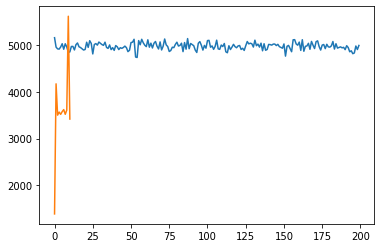

In [449]:
plt.plot(activations[list(activations.keys())[0]][40])
#plt.plot(activations["conv1d_5"][:,0,0])
#plt.plot(activations["lambda_54"][40,:,0])
plt.plot(activations[list(activations.keys())[4]][40,:,0])
#plt.plot(activations["max_pooling1d_46"][900,:,0])
#activations[list(activations.keys())[6]]

In [413]:
y_[y_==1].shape[0]/y_.shape[0]

1.0

In [473]:
model.evaluate(x_train, y_train)


7/7 [==============================] - 0s 827us/step - loss: 1.0000 - sparse_categorical_accuracy: 0.0000e+00 - binary_accuracy: 0.0000e+00


[1.0, 0.0, 0.0]

In [458]:
#model = keras.models.load_model('g2model.h5')

loss, accuracy = model.evaluate(x_train, y_train)

print("Test accuracy", accuracy)
print("Test loss", loss)



7/7 [==============================] - 0s 837us/step - loss: 1.0000 - sparse_categorical_accuracy: 0.0000e+00 - binary_accuracy: 0.0000e+00


ValueError: too many values to unpack (expected 2)

In [251]:
model.evaluate(x_test)

7/7 [==============================] - 0s 616us/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.0000e+00


[0.0, 0.0]

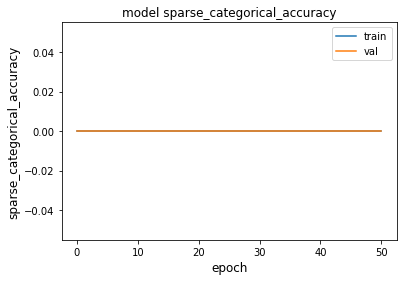

In [288]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()


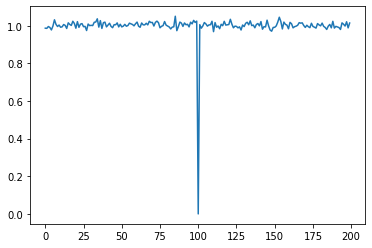

In [61]:
plt.plot(x_train[0])

In [65]:
y_train[0]

1

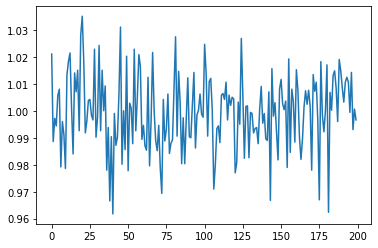

In [67]:
plt.plot(x_train[1])

In [89]:
np.loadtxt('./simulation/data/s1set10.txt', skiprows=9, max_rows=1)


array(1.)

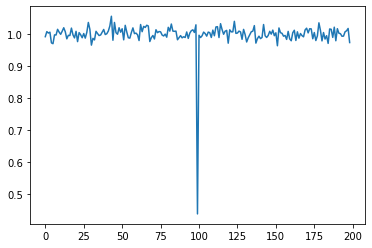

In [100]:
np.loadtxt('./simulation/data/s1set10.txt', skiprows=9, max_rows=1)
binnum = int(np.loadtxt('./simulation/data/s1set10.txt', skiprows=4, usecols=1, max_rows=1, delimiter=':'))
plt.plot(np.loadtxt('./simulation/data/s1set10.txt', skiprows=13, max_rows=binnum))


In [98]:
binnum = int(np.loadtxt('./simulation/data/s1set10.txt', skiprows=4, usecols=1, max_rows=1, delimiter=':'))


In [101]:
s1 = Simulator.simulator(gt=0.5, Nbins=200, width=1., Ndet=1e6, sps=1., laser=0., ther=0., non=0.)


In [102]:
s1.get_data(s1.distribution)

'please check your input distribution'

In [27]:
filenames = []
x_ = []
y_ = []
filenames = ['./simulation/data/s1set'+str(i)+'.txt' for i in range(500)]+['./simulation/data/s2set'+str(i)+'.txt' for i in range(500)]

for filename in filenames: 
    data = s2.load_data(filename)
    x_.append(data[1])
    y_.append(data[0])

In [29]:
len(x_)

1000

In [213]:
# convert the keras model into TF lite
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: /tmp/tmprx9d0fve/assets


In [4]:
model = keras.models.load_model('g2model.h5')


In [ ]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

q_aware_model.summary()


In [ ]:
model.trainable_weights

In [3]:
import numpy as np


In [113]:
binnum = np.arange(-100,100)
g2 = np.arange(200,400)
value = np.arange(400,600)
st = np.arange(30)
data = np.zeros((30,3,200))

In [114]:
for i in st:
    data[i] = np.array([binnum,g2,value])

In [ ]:
for i in st:
    try:
        data[i] = np.array([signal,binnum,his])
    except:
        raise Exception('Input distribution is incorrect, please check the light sources fraction.')
        break
        

In [115]:
filename = 'test2' + '.csv'
            
file = open(filename,'w')  # 'a' for appending
file.write('data array format: (N seperate measurements  [binnumber  normalized g2 signal  binvalues]  data) ')
file.write('\n')
np.savetxt(file, data[:,2,:], header='histogram values (int)') 
np.savetxt(file, data[:,1,:], header='normalized g2 signal') 
np.savetxt(file, data[:,0,:], header='bin number array') 
file.close()


In [35]:
def load_data(self, filename):
        gt = np.loadtxt(filename, skiprows=1, max_rows=1)
        binnum = int(np.loadtxt(filename, skiprows=4, usecols=1, max_rows=1, delimiter=':'))
        g2 = np.loadtxt(filename, skiprows=12, max_rows=binnum)
        
        return [gt, g2]

(20, 200)

In [81]:
        parse = np.loadtxt(filename, skiprows=1, max_rows=1000000)
        data = np.zeros((parse.shape[0]//3, 3, parse.shape[1]))
        data[:,0,:] = parse[:parse.shape[0]//3,:]
        data[:,1,:] = parse[parse.shape[0]//3:parse.shape[0]*2//3,:]
        data[:,2,:] = parse[parse.shape[0]*2//3:,:]
        

In [117]:
def load_data(filename):
    '''
    input: path + filename
    output: data sets, same format with generated data sets
    '''
    # I must say, this is a stupid way for parsing. I will switch to pandas once available
    parse = np.loadtxt(filename, skiprows=1, max_rows=1000000)
    data = np.zeros((parse.shape[0]//3, 3, parse.shape[1]))
    data[:,0,:] = parse[:parse.shape[0]//3,:]
    data[:,1,:] = parse[parse.shape[0]//3:parse.shape[0]*2//3,:]
    data[:,2,:] = parse[parse.shape[0]*2//3:,:]
    
    return data
data=load_data('./test2.csv')

In [172]:
def get_truth(data,thr):
    '''
    input: data array, threshhold for classifying sps or not sps
    output: a binary result array
    '''
    signal = data[:,1,:]
    binnumber = data[:,2,:]
    
    # create a 1d-array of g2(0) values
    g2zero = np.ndarray.flatten(np.array([signal[i][binnumber[i]==0] for i in range(signal.shape[0])]))
    binary = np.zeros(g2zero.shape)
    
    # if it's smaller than the threshold then make it to 1 (it is a sps)
    binary[[g2zero[i]<thr for i in range(len(g2zero))]] = 1
    
    return binary

In [120]:
    signal = data[:,1,:]
    binnumber = data[:,2,:]
    signal[:,binnumber==0.]

In [169]:
    g2zero = np.ndarray.flatten(np.array([signal[i][binnumber[i]==0] for i in range(signal.shape[0])]))
    thr = 3000

In [171]:
binary

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])